Goal: create maps of street networks, but only within a buffer around a geocoded place.

Next goal: functions to measure and visualize urban indicators.

Steps:
- write code to plot heatmap of point density [DONE]
- convert heatmap code to function [DONE]
- write code to clip heatmap to buffer ring [DONE]
- write code to get osm POI data based on category
- allow get_buffer() fxn to take coord tuple param
- put plotting of text as separate fxn (and reflect map content)

Ideas for Urban Indicators:
- intersection density (hexbin/heatmap) [DONE]
- density of x-height buildings (hexbin/heatmap) [DONE]
- density of x kind of amenity (hexbin/heatmap)
    - sustenance (restaurants, bars, etc.)
    - education (school, college, university, etc.)
    - healthcare (clinic, hospital, etc.)
    - public service (fire station, town hall, police, etc.)
- density of shops [DONE]
- isochrone from geocoded point
- betweenness centrality of street intersections [DONE]

Step 1: Import packages

In [22]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import networkx as nx

Step 2: Generate buffer around location of interest

In [23]:
# Set name for Nominatim query
query = "Barangka Ibaba"
buffer_dist = 4_000

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

c:\Users\Kurt\miniconda3\envs\geopython\Lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


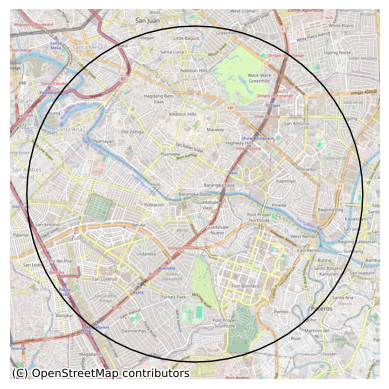

In [24]:
# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

Step 3: Extract street network within buffer then pre-process

In [25]:
# Get road network within buffer
graph = ox.graph_from_polygon(
    buffer.geometry[0],
    network_type="all_private",
    retain_all=True,
    simplify=True
)

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [26]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [27]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([2, 4, 1, 3, 5, 6])

In [28]:
streets.head()

osmid  oneway  lanes  ref  \
u        v          key                                                         
12067613 962953430  0    [29256184, 188165094, 188165111]    True      2    1   
         12067619   0                           264965502    True      4    1   
12067619 6970838871 0                           927257054    True      1  NaN   
         8459730704 0                           671955931    True      2    1   
12067627 8242414108 0                            22598208   False      2  NaN   

                                          name   highway maxspeed reversed  \
u        v          key                                                      
12067613 962953430  0      [EDSA, Shaw Tunnel]     trunk       60    False   
         12067619   0                     EDSA     trunk       60    False   
12067619 6970838871 0    Starmall Service Road   service      NaN    False   
         8459730704 0                     EDSA     trunk       60    False   
12067627 8242414108 0               Apo Street  tertiary      NaN    False   

                          length tunnel  \
u        v          key                   
12067613 962953430  0    860.735    yes   
         12067619   0    186.206    NaN   
12067619 6970838871 0      5.516    NaN   
         8459730704 0    194.543    NaN   
12067627 8242414108 0      6.785    NaN   

                                                                  geometry  \
u        v          key                                                      
12067613 962953430  0    LINESTRING (13475833.935 1641363.380, 13475829...   
         12067619   0    LINESTRING (13475833.935 1641363.380, 13475821...   
12067619 6970838871 0    LINESTRING (13475743.466 1641194.729, 13475738...   
         8459730704 0    LINESTRING (13475743.466 1641194.729, 13475668...   
12067627 8242414108 0    LINESTRING (13474860.424 1639875.264, 13474853...   

                        access width bridge service junction  
u        v          key                                       
12067613 962953430  0      NaN   NaN    NaN     NaN      NaN  
         12067619   0      NaN   NaN    NaN     NaN      NaN  
12067619 6970838871 0      NaN   NaN    NaN     NaN      NaN  
         8459730704 0      NaN   NaN    NaN     NaN      NaN  
12067627 8242414108 0      NaN   NaN    NaN     NaN      NaN

Step 4: Plotting the street network and intersection heatmap

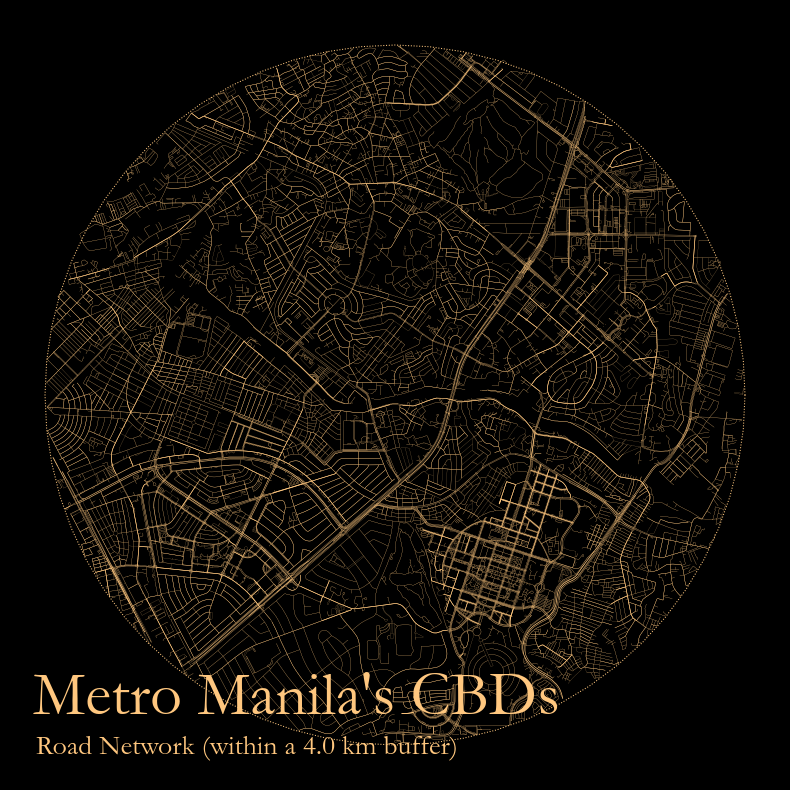

In [59]:
# Plot street network using custom functions (defined in scripts file)
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    title="Metro Manila's CBDs",
    # subtitle="Road network",
    width_factor=0.1,
    color_scheme="copper"
)

# plot_heatmap(
#     intersections,
#     "street_count",
#     bins=500,
#     ax=ax,
#     alpha=0.7,
#     color_scheme="BuPu_r",
#     bounds=ring_bounds
# )

Part B: Generating a heatmap for other POIs

Step 1: Extract POIs within buffer

In [30]:
# Extract all shops within the buffer
pois = ox.features_from_polygon(
    buffer.geometry[0],
    {
        # "shop": True,
        # "amenity": ["fast_food", "restaurant", "cafe"]
        "building:levels": [str(i) for i in range(20,100)],
    }
)

# Examine number of rows and columns
pois.shape

(736, 79)

Step 2: Clean up POI data

In [31]:
# Import drop_nan_cols function we created
from urban_indicators_scripts import drop_nan_cols, filter_elem_type

# Apply imported function
# Parameters: gdf, max % of rows that are NaNs
pois = drop_nan_cols(pois, 0.75)

In [32]:
# Examine # of rows & cols after pre-processing
pois.shape

(736, 8)

In [33]:
# Flatten column indices
# (this should be in the function)
pois = pois.reset_index()

pois.head()

,element_type,osmid,geometry,addr:city,name,nodes,building,building:levels,height,building:part
0,way,22788808,"POLYGON ((121.02140 14.55751, 121.02152 14.557...",Makati,Philamlife Tower,"[244891956, 244891957, 244891958, 244891959, 2...",commercial,48,200,NaN
1,way,24547892,"POLYGON ((121.03491 14.56385, 121.03491 14.563...",NaN,Hidalgo Place,"[266904913, 5209772931, 5209772930, 266904914,...",residential,24,87.6,NaN
2,way,24547895,"POLYGON ((121.03508 14.56457, 121.03504 14.564...",NaN,Rizal Tower,"[266905127, 2312911335, 2312911334, 2312911330...",apartments,47,161,NaN
3,way,24547947,"POLYGON ((121.03508 14.56529, 121.03488 14.565...",NaN,Luna Gardens,"[266905163, 266905164, 266905165, 266905166, 2...",apartments,39,134.9,NaN
4,way,24547950,"POLYGON ((121.03551 14.56572, 121.03551 14.565...",NaN,Amorsolo East,"[266905215, 266905216, 266905217, 266905218, 2...",residential,30,107,NaN


In [34]:
# Assign weight to all POIs (for heatmap)
# relevant for other POI types (e.g. shops)
pois["weight"] = 1.0

In [35]:
# Reproject to Pseudo-Mercator
pois = pois.to_crs("EPSG:3857")

In [36]:
# Set feature geometries as their centroids
# (this should be in the function)
pois["geometry"] = pois["geometry"].centroid
pois.shape

(736, 11)

In [37]:
# If value in `building:levels` is a list, get max value
pois["building:levels"] = pois["building:levels"].apply(
    lambda x: max(x) if isinstance(x, list) == True else x
)

# Convert `building:levels` data type to int
pois["building:levels"] = pois["building:levels"].astype(int)

Step 3: Plot POI density heatmap

d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:397: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:401: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


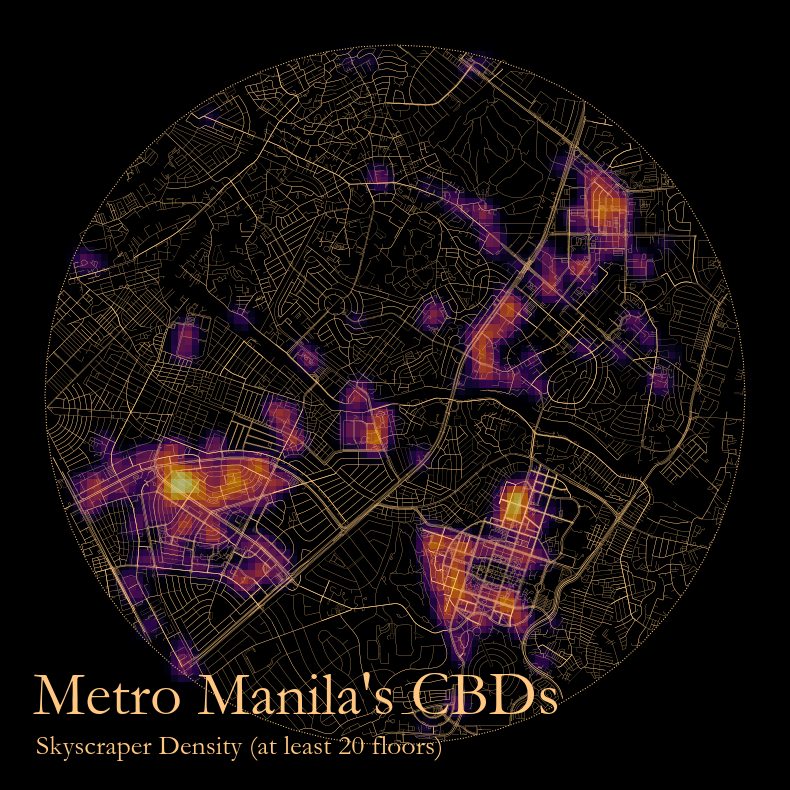

In [40]:
# Return fig, ax, and bounds from plot_streets()...
# ...for use in plot_heatmap()
fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    title="Metro Manila's CBDs",
    subtitle="Skyscraper Density (at least 20 floors)",
    width_factor=0.1,
    color_scheme="copper"
)

plot_heatmap(
    pois,
    "building:levels",
    bins=100,
    ax=ax,
    alpha=0.7,
    color_scheme="inferno",
    bounds=ring_bounds
)

Part C: Visualizing betweenness centrality of street intersections

Step 1: Calculate betweenness centrality per node

In [41]:
len(intersections)

16383

In [52]:
# Can't run for very big networks, even with k ~= 1% of total no. of nodes
bc = nx.betweenness_centrality(graph, weight="street_count", k=1_000)

Step 2: Join betweenness values to each node via osmid

In [53]:
nx.set_node_attributes(graph, bc, "bc")

Step 3: Convert graph to GDFS, then preprocess

In [54]:
intersections, streets = ox.graph_to_gdfs(graph)

In [55]:
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [56]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([2, 4, 1, 3, 5, 6])

In [57]:
# Multiply by 1,000 (since function calculates log of heatmap)
intersections["bc_1k"] = intersections["bc"] * 1_000

Step 4: Plot betweenness centrality!

d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:397: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\WORK\ONLINE COURSES\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:401: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


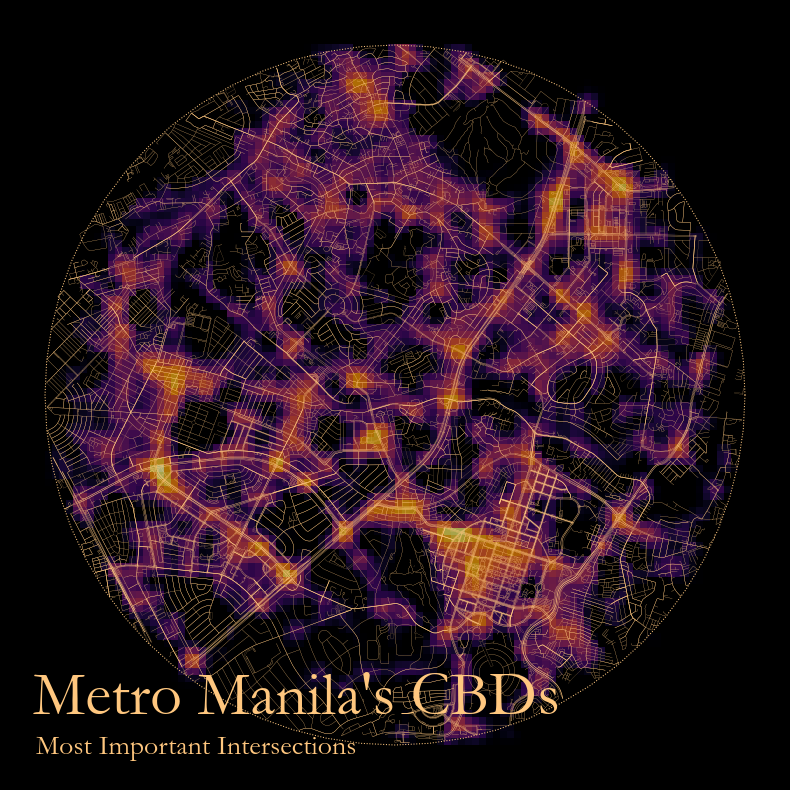

In [58]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    title="Metro Manila's CBDs",
    subtitle="Most Important Intersections",
    width_factor=0.1,
    color_scheme="copper"
)

# Plot heatmap of betweenness centrality
plot_heatmap(
    intersections,
    "bc_1k",
    ax=ax,
    alpha=0.7,
    color_scheme="inferno",
    bounds=ring_bounds
)